# Pipeline for image size estimation

Imports

In [2]:
# basics
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
# file work
import os
import json
# computer vision
import cv2
import torch
import laser_detection as ld
# models
from segment_anything import sam_model_registry, SamPredictor
from easy_ViTPose import VitInference
from huggingface_hub import hf_hub_download

/cluster/tufts/fuzzywuzzy/jbrand12/condaenv/fzwz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 0: Assign input point to each image

run: 'python3 label.py' to get json of image names and input points (change path to folder in script)

## Step 1: Load image data from json

The below are modifiable variables you can change depending on what dataset you are running

In [3]:
# ALL DATA
json_file = '../data/valid_QC.json'  # must contain input labels
image_folder = '../data/valid_QC'
mask_folder = '../data/valid_QC_masks'  # can be empty to start

# SAMPLE DATA
# json_file = 'sample_data/red_lasers/sample_data.json'  # must contain input labels
# image_folder = 'sample_data/red_lasers/sample_data'
# mask_folder = 'sample_data/red_lasers/sample_data_masks'  # can be empty to start

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [4]:
len(image_data)

187

## Step 2: Run images through SAM to prep for laser detection

### ***only need to run this code once to get masks!!!

Set up SAM

In [4]:
# select checkpoint and model type
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

# define predictor
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# change device if cuda is available
if torch.cuda.is_available():
    sam.to(device='cuda')

predictor = SamPredictor(sam)

In [5]:
def generate_mask(im, input_point):
    input_label = np.array([1])
    predictor.set_image(im)
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    # return best mask
    return masks[np.argmax(scores)]

Iterate through images and get mask

In [6]:
from tqdm import tqdm
# iterate through each entry in the JSON data
for image_name, im_data in tqdm(image_data.items(), desc="Processing Images"):
    image_path = os.path.join(image_folder, image_name)
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is not None:
        # extract coordinates
        input_point = np.array([im_data['input_point']])
        # Generate the mask
        mask = generate_mask(img, input_point)
        mask = mask.astype(np.uint8)
        
        # Define the mask filename
        mask_filename = os.path.splitext(image_name)[0] + "_mask.png"
        mask_path = os.path.join(mask_folder, mask_filename)
        
        # Save the mask
        cv2.imwrite(mask_path, mask)
        
        # Update the JSON data with the mask filename
        image_data[image_name]['mask'] = mask_filename

Processing Images: 100%|██████████| 187/187 [01:57<00:00,  1.59it/s]


## Step 3: laser point detection

In [7]:
idx = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="detecting lasers"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    source = cv2.imread(image_path)

    # Load the mask
    mask_filename = info['mask']
    mask_path = os.path.join(mask_folder, mask_filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
    mask = mask > 0  # need to convert to boolean values

    if source is not None:
        # run laser detection image
        points = ld.detect_red_laser_points(source, mask)
        
        # Update the JSON data with the mask filename
        image_data[image_name]['laser_points'] = points

detecting lasers: 100%|██████████| 187/187 [20:14<00:00,  6.50s/it]


### Step 4: Run VitPose

In [8]:
# define model parameters
MODEL_SIZE = 'b'
YOLO_SIZE = 'n'
DATASET = 'apt36k'
ext = '.pth'
ext_yolo = '.pt'

# download model_path and yolo_path
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, 
                        f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo
print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [9]:
# initialize model
model = VitInference(model_path, yolo_path, MODEL_SIZE, dataset=DATASET)

In [10]:
count = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="ViTPose"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    # get keypoints
    img_arr = np.array(img, dtype=np.uint8)
    keypoints = model.inference(img_arr)

    if keypoints:
        # store results
        shoulder = (int(keypoints[0][3][1]), int(keypoints[0][3][0]))
        rump = (int(keypoints[0][4][1]), int(keypoints[0][4][0]))
      
        # Update the JSON data with shoulder and rump
        image_data[image_name]['shoulder_rump'] = [shoulder, rump]
    else:
        count += 1
        # TODO how do we want to handle this case in the json?
        image_data[image_name]['shoulder_rump'] = None

print(f"vitpose failed for {count} images")

ViTPose: 100%|██████████| 187/187 [00:32<00:00,  5.76it/s]

vitpose failed for 14 images


### Step 5: get distances

In [5]:
measured_df = pd.read_csv('../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

Get dictionaries for conversions

In [6]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

Calculating Final Distances:   0%|          | 0/187 [00:00<?, ?it/s]

Predicted: 6.818057092277051	 Actual: 37.37861635	 Error = 0.818
Predicted: 64.56627767803711	 Actual: 63.20911765	 Error = 0.021
Predicted: 9.346289752650176	 Actual: 64.22170543	 Error = 0.854
Predicted: 84.94811320754717	 Actual: 27.38267717	 Error = 2.102
Predicted: 63.44714285714284	 Actual: 62.64761905	 Error = 0.013
Predicted: 46.3542	 Actual: 47.13861386	 Error = 0.017
Predicted: 6.392857142857142	 Actual: 56.71964286	 Error = 0.887
Predicted: 5.9171806167400876	 Actual: 41.86	 Error = 0.859
Predicted: 90.04108843537415	 Actual: 28.72553191	 Error = 2.135


Calculating Final Distances:  37%|███▋      | 70/187 [00:00<00:00, 200.20it/s]

Predicted: 56.80178571428571	 Actual: 56.86902655	 Error = 0.001
Predicted: 21.40132144037	 Actual: 57.19469027	 Error = 0.626
Predicted: 45.41587301587301	 Actual: 58.7496063	 Error = 0.227
Predicted: 11.55004470938897	 Actual: 51.83267974	 Error = 0.777
Predicted: 56.99282051282051	 Actual: 54.90886076	 Error = 0.038
Predicted: 49.801758445164275	 Actual: 50.08169014	 Error = 0.006
Predicted: 56.639354838709664	 Actual: 54.55	 Error = 0.038
Predicted: 25.9396875	 Actual: 26.90520833	 Error = 0.036
Predicted: 57.999428571428574	 Actual: 53.49142857	 Error = 0.084
Predicted: 41.236635514018694	 Actual: 39.61111111	 Error = 0.041
Predicted: 59.383124999999986	 Actual: 59.41666667	 Error = 0.001
Predicted: 43.67664974619289	 Actual: 42.54416244	 Error = 0.027
Predicted: 53.44408602150538	 Actual: 61.18494624	 Error = 0.127
Predicted: 42.17267973856209	 Actual: 44.34640523	 Error = 0.049
Predicted: 53.903055555555554	 Actual: 63.77031836	 Error = 0.155
Predicted: 66.5429268292683	 Actual:

Calculating Final Distances:  49%|████▉     | 92/187 [00:00<00:00, 146.39it/s]

Predicted: 65.14582524271844	 Actual: 63.69230769	 Error = 0.023
Predicted: 47.03688524590163	 Actual: 47.29256198	 Error = 0.005
Predicted: 49.08659999999999	 Actual: 50.19009901	 Error = 0.022
Predicted: 56.99747899159664	 Actual: 61.61680672	 Error = 0.075
Predicted: 173.88	 Actual: 47.42451613	 Error = 2.666
Predicted: 5.641169698365185	 Actual: 35.34736842	 Error = 0.84
Predicted: 7.123823451209785	 Actual: 50.38504673	 Error = 0.859
Predicted: 67.76106666666666	 Actual: 67.12368421	 Error = 0.009
Predicted: 9.755404089581303	 Actual: 59.19245283	 Error = 0.835
Predicted: 55.02307692307692	 Actual: 54.93461538	 Error = 0.002
Predicted: 64.83278370514064	 Actual: 66.18096883	 Error = 0.02
Predicted: 63.63333333333333	 Actual: 67.85	 Error = 0.062
Predicted: 58.39294117647058	 Actual: 57.868	 Error = 0.009
Predicted: 24.05427027027027	 Actual: 23.85464481	 Error = 0.008
Predicted: 65.94503816793893	 Actual: 65.90545455	 Error = 0.001
Predicted: 8.662553533190575	 Actual: 62.68149132

Calculating Final Distances: 100%|██████████| 187/187 [00:00<00:00, 265.69it/s]


Predicted: 59.872631578947356	 Actual: 66.04525547	 Error = 0.093
Predicted: 9.741176470588234	 Actual: 61.6328125	 Error = 0.842
Predicted: 57.862692307692306	 Actual: 58.11923077	 Error = 0.004
Predicted: 48.7275294117647	 Actual: 52.27764706	 Error = 0.068
Predicted: 57.934444444444445	 Actual: 58.84528302	 Error = 0.015
Predicted: 69.24666666666666	 Actual: 61.50857143	 Error = 0.126
Predicted: 30.64088495575221	 Actual: 63.48976991	 Error = 0.517
Predicted: 36.24835937499999	 Actual: 40.00389105	 Error = 0.094
Predicted: 42.548159999999996	 Actual: 29.9552	 Error = 0.42
Predicted: 76.08055759354365	 Actual: 35.9392638	 Error = 1.117
Predicted: 45.20080808080807	 Actual: 44.90693069	 Error = 0.007
Predicted: 64.92837837837837	 Actual: 61.70133333	 Error = 0.052
100 images with less than 10 percent error


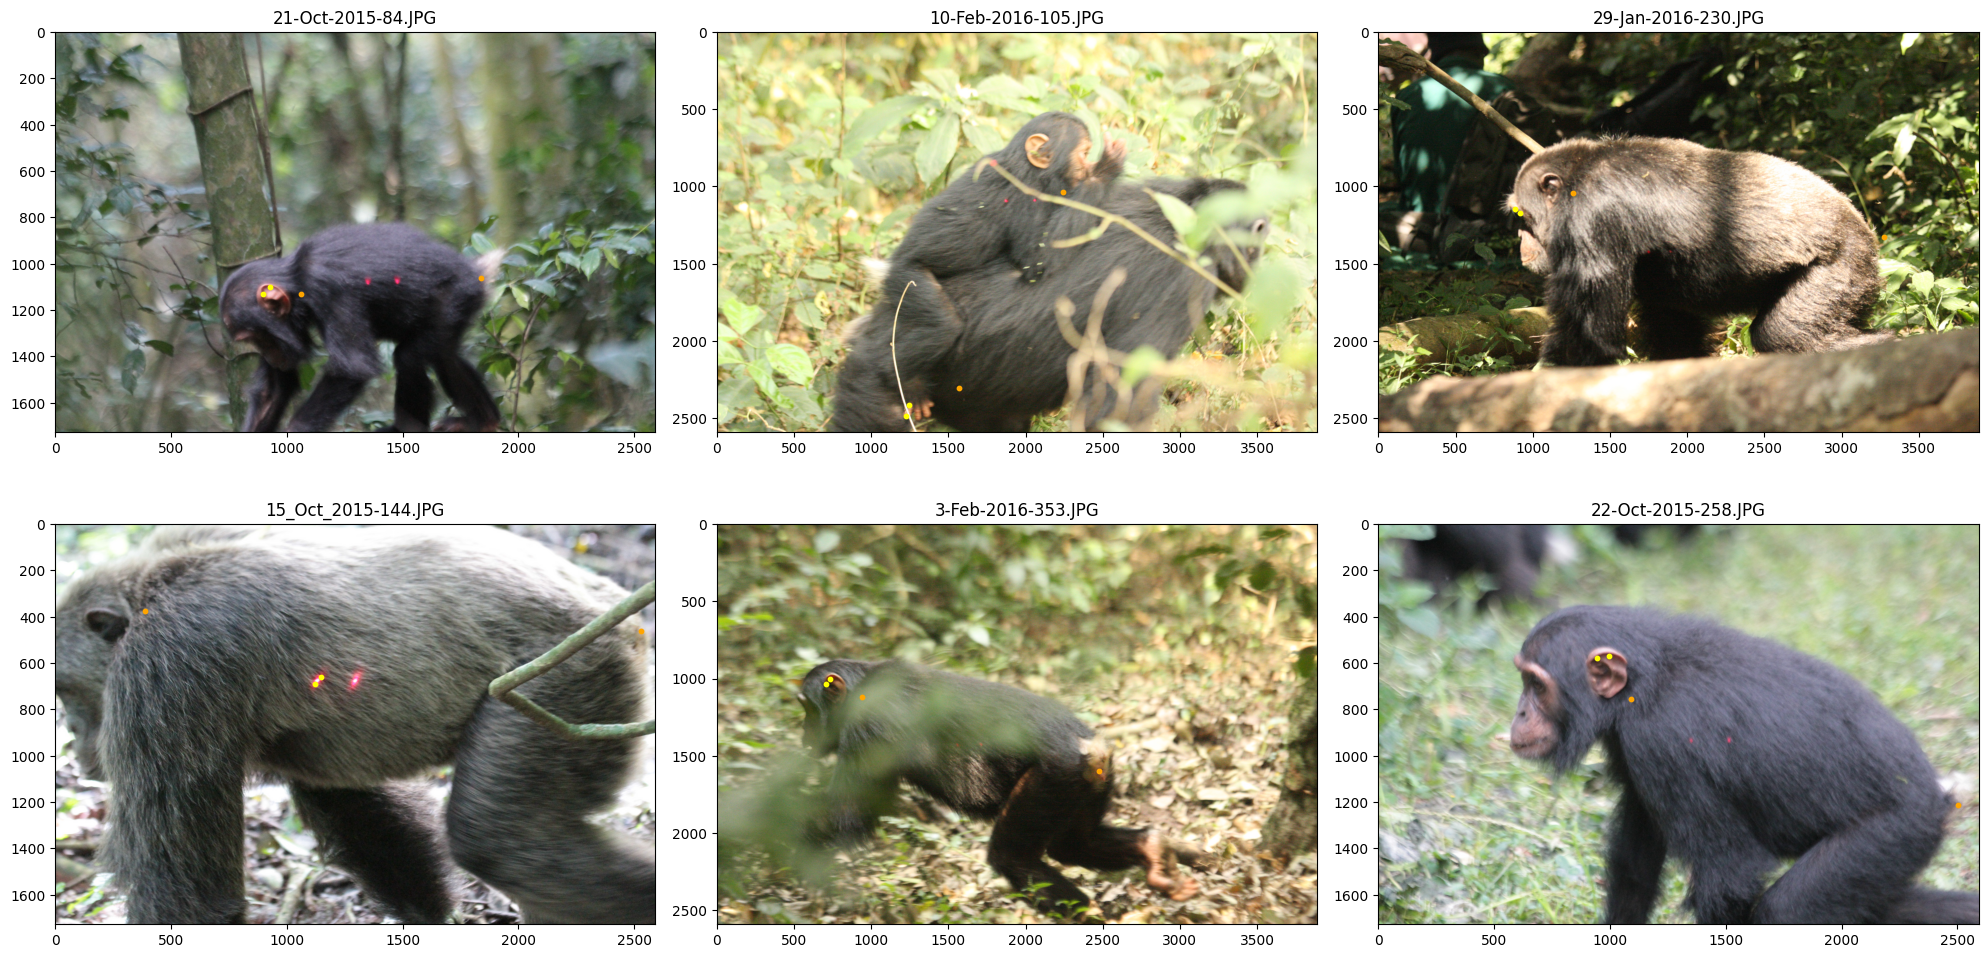

In [31]:
# iterate through each entry in json
count = 0
errors = []
for image_name, info in tqdm(image_data.items(), desc="Calculating Final Distances"):
    try:
        # distances in pixels
        laser_points = info['laser_points']
        body_points = info['shoulder_rump']

        # calculate ratio
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1)
        body_dist = round(math.dist(body_points[0], body_points[1]), 1)
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        # compare results
        predicted_length = laser_in / ratio
        true_length = body_length[photo_id]
        error = round(abs(predicted_length - true_length) / true_length, 3)
        errors.append(error * 100)
        print(f"Predicted: {predicted_length}\t Actual: {true_length}\t Error = {error}")
        
        if error < 0.10:
            count += 1
    except:
        pass

print(f"{count} images with less than 10 percent error")
plt.tight_layout()
plt.show()

### Save final results

In [14]:
# Write the updated JSON data to a file
with open(json_file, 'w') as file:
    json.dump(image_data, file, indent=4)

print(f"Updated data saved to {json_file}")

Updated data saved to ../data/valid_QC.json
